In [1]:
# Import the required libraries.
# pandas is a powerful library used to manipulate and explore the data
import pandas as pd
import numpy as np
import itertools
# matplotlib is used to plot the data
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['text.color'] = 'k'

In [2]:
# import the data using pandas.read_csv('file_path')
df = pd.read_csv('dataset.csv')

In [3]:
# view the first 10 rows of the dataframe using df.head() function
df.head(10)

,date,vendor_id,item_id,item_price,item_cnt_day
0,02.01.2013,59,22154,999.00,1.0
1,03.01.2013,25,2552,899.00,1.0
2,05.01.2013,25,2552,899.00,-1.0
3,06.01.2013,25,2554,1709.05,1.0
4,15.01.2013,25,2555,1099.00,1.0
5,10.01.2013,25,2564,349.00,1.0
6,02.01.2013,25,2565,549.00,1.0
7,04.01.2013,25,2572,239.00,1.0
8,11.01.2013,25,2572,299.00,1.0
9,03.01.2013,25,2573,299.00,3.0


In [4]:
# check whether null values are present in the dataframe with the 
# help of pandas.isnull() function
pd.isnull(df).sum()

date            0
vendor_id       0
item_id         0
item_price      0
item_cnt_day    0
dtype: int64

In [5]:
# check the data types for each columns
df.dtypes

date             object
vendor_id         int64
item_id           int64
item_price      float64
item_cnt_day    float64
dtype: object

In [6]:
# change the data type for date column to date time 
df['date'] = pd.to_datetime(df['date'])

In [7]:
df.dtypes

date            datetime64[ns]
vendor_id                int64
item_id                  int64
item_price             float64
item_cnt_day           float64
dtype: object

In [8]:
# total number of unique values in all columns
df.nunique(axis=0)

date             1034
vendor_id          60
item_id         21807
item_price      19993
item_cnt_day      198
dtype: int64

In [9]:
# Data Processing for vendor_id '31'
# applying groupby() function to group the data on vendor_id '31' 
# and set date index 
vendors = df.groupby(df['vendor_id'])
vendor_31 = vendors.get_group(31).set_index('date').drop(['vendor_id'], axis=1)

In [10]:
# I need to create a column 'revenue' for our problem statement requirement
vendor_31['revenue'] = vendor_31.item_price * vendor_31.item_cnt_day
vendor_31

,item_id,item_price,item_cnt_day,revenue
date,,,,
2013-03-01,4906,1794.0,2.0,3588.0
2013-02-01,4906,1789.0,1.0,1789.0
2013-11-01,4890,799.0,1.0,799.0
2013-01-26,4901,1499.0,1.0,1499.0
2013-01-25,4901,1499.0,1.0,1499.0
...,...,...,...,...
2015-01-10,1540,1999.0,1.0,1999.0
2015-07-10,1540,1999.0,1.0,1999.0
2015-10-10,1540,1999.0,1.0,1999.0


In [11]:
vendor_31.index

DatetimeIndex(['2013-03-01', '2013-02-01', '2013-11-01', '2013-01-26',
               '2013-01-25', '2013-01-23', '2013-01-14', '2013-12-01',
               '2013-11-01', '2013-08-01',
               ...
               '2015-10-25', '2015-02-10', '2015-10-21', '2015-10-24',
               '2015-10-26', '2015-01-10', '2015-07-10', '2015-10-10',
               '2015-10-23', '2015-10-26'],
              dtype='datetime64[ns]', name='date', length=235636, freq=None)

In [28]:
# our current datetime data can be hard to work with, therefore 
# I will use the average revenue for that month instead, and we 
# are using the start of each month as the timestamp.
y_31 = vendor_31['revenue'].resample('MS').mean()
y_31.describe()

count      36.000000
mean     1007.054191
std       190.715793
min       706.474090
25%       859.943478
50%      1003.980160
75%      1128.582777
max      1416.572300
Name: revenue, dtype: float64

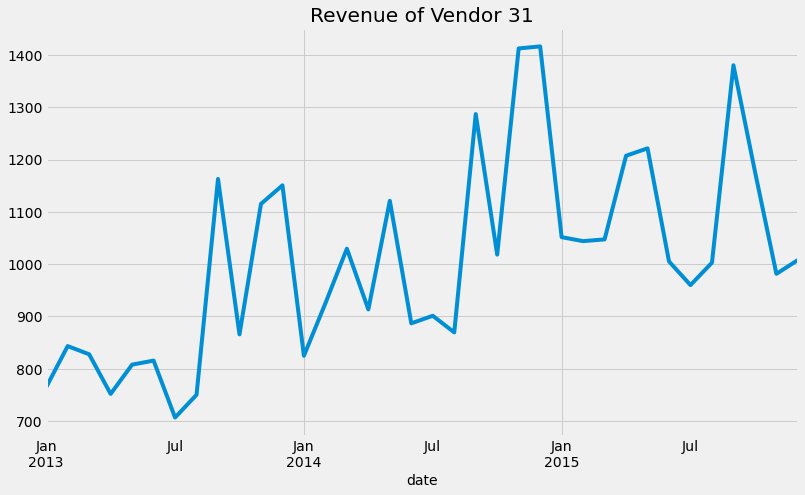

In [29]:
# visualizing revenue for vendor 31
y_31.plot(figsize=(12, 7))
plt.title('Revenue of Vendor 31')
plt.show()
# some distinguishable patterns appear when we plot the data. 
# The time-series has seasonality pattern, such as sales are 
# always low at the beginning of the year and high at the end of 
# the year. There is always an upward trend within any single year 
# with a couple of low months in the mid of the year.

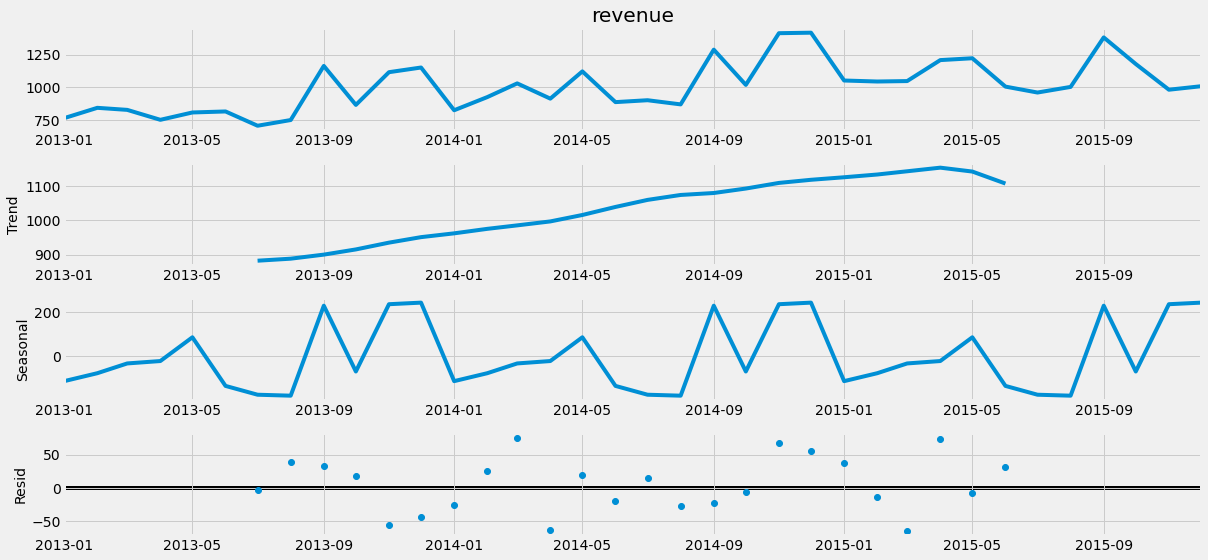

In [14]:
# I can also visualize our data using a method called time-series 
# decomposition that allows us to decompose our time series into three 
# distinct components: trend, seasonality, and noise.
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 17, 8
decomposition = sm.tsa.seasonal_decompose(y_31, model='additive')
fig = decomposition.plot()
plt.show()
# The plot shows that the data has both trend & seasonality.

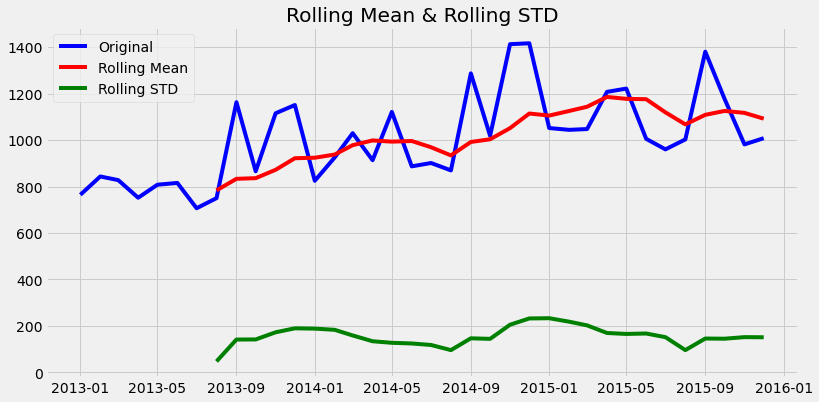

In [15]:
# Statistical test: To confirm our visual observation on the above plot, 
# I will use the Dickey-Fuller Hypothesis testing.
# import adfuller
from statsmodels.tsa.stattools import adfuller

# calculate rolling statistics
rollmean = y_31.rolling(window=8, center=False).mean()
rollstd = y_31.rolling(window=8, center=False).std()

# perform the Dickey Fuller test
dftest = adfuller(y_31)

# plot rolling statistics
fig = plt.figure(figsize=(12, 6))
orig = plt.plot(y_31, color='blue', label='Original')
mean = plt.plot(rollmean, color='red', label='Rolling Mean')
std = plt.plot(rollstd, color='green', label='Rolling STD')
plt.legend(loc='best')
plt.title('Rolling Mean & Rolling STD')
plt.show()

In [16]:
# print dickey fuller test results
print('Results of Dickey-Fuller Test')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistics', 
                                        'p-values', '#Lags used', 
                                        'No.of observations used'])
for key, revenue in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = revenue
print(dfoutput)
# The results show that the sales are unstable.
# The hypothesis for this test is that the time series is stationary 
# because the p-value < 0.05

Results of Dickey-Fuller Test
Test Statistics            -3.798664
p-values                    0.002921
#Lags used                  0.000000
No.of observations used    35.000000
Critical Value (1%)        -3.632743
Critical Value (5%)        -2.948510
Critical Value (10%)       -2.613017
dtype: float64


In [17]:
# Time series forecasting with SARIMA
# The most commonly used method for time-series forecasting, known as ARIMA, 
# which stands for Autoregressive Integrated Moving Average.
# ARIMA models are denoted with the notation ARIMA(p, d, q). 
# These three parameters account for seasonality, trend, and noise in data
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [18]:
# This step is parameter Selection for our ARIMA Time Series Model. 
# Our goal here is to use a “grid search” to find the optimal 
# set of parameters that yields the best performance for our model.
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_31[:-1],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_invertibility=False)
            results_31 = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results_31.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:586.5922654898606
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:566.2038158661096
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:309.1364450659164
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:310.2498298328164
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:511.282207046139
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:512.8974549376496
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:310.21917158085637
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:312.2957951402962
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:553.440969161294
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:533.273254619802
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:306.675759729866
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:308.67015015447686
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.52373727605107
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:500.6416789356509
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:308.669663891693
C:\Users\luqman\anaconda3\envs\env_ml\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


In [19]:
# The above output suggests that SARIMAX(0, 1, 1)x(0, 1, 1, 12) yields 
# the lowest AIC value of 286.94. Therefore we should consider this 
# to be optimal option.
mod = sm.tsa.statespace.SARIMAX(y_31[:-1],
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_invertibility=False)

results_31 = mod.fit()

print(results_31.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7029      0.520     -1.352      0.176      -1.722       0.316
ma.S.L12      -0.5963      2.094     -0.285      0.776      -4.700       3.508
sigma2      1.639e+04   2.49e+04      0.657      0.511   -3.25e+04    6.53e+04


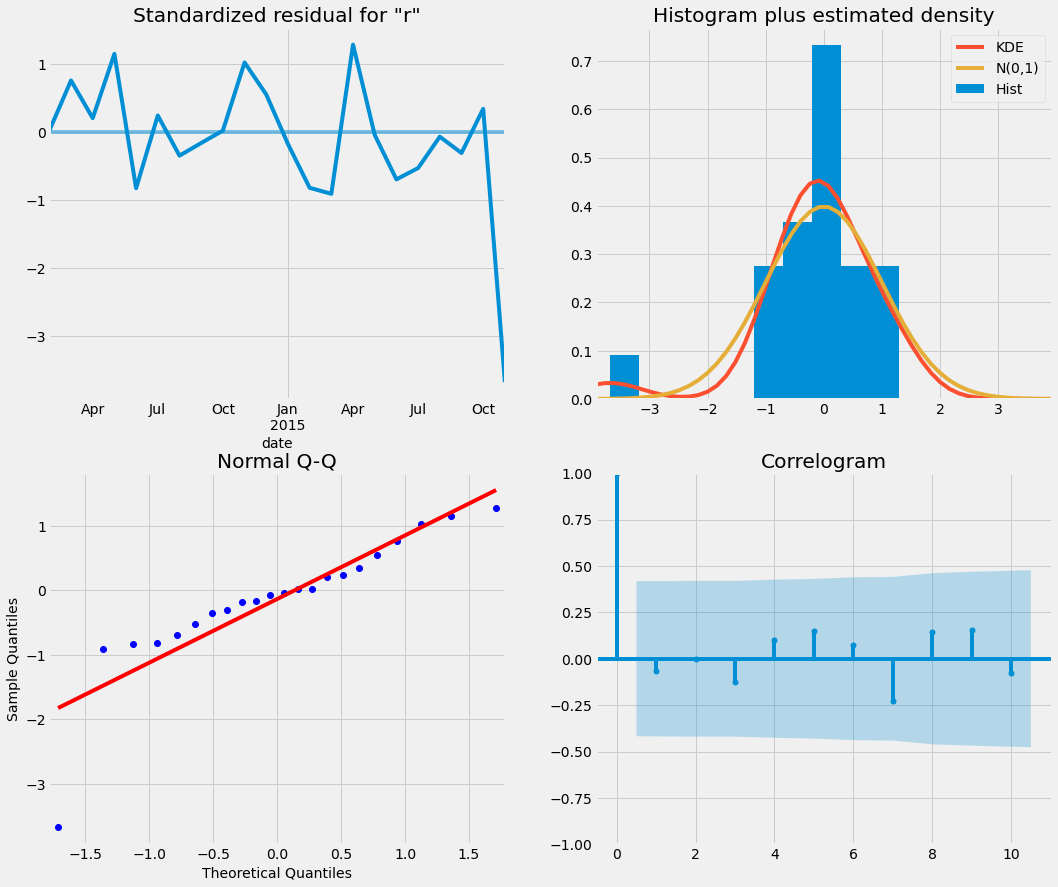

In [20]:
# Diagnostic plots for standardized residuals
results_31.plot_diagnostics(figsize=(16, 14))
plt.show()

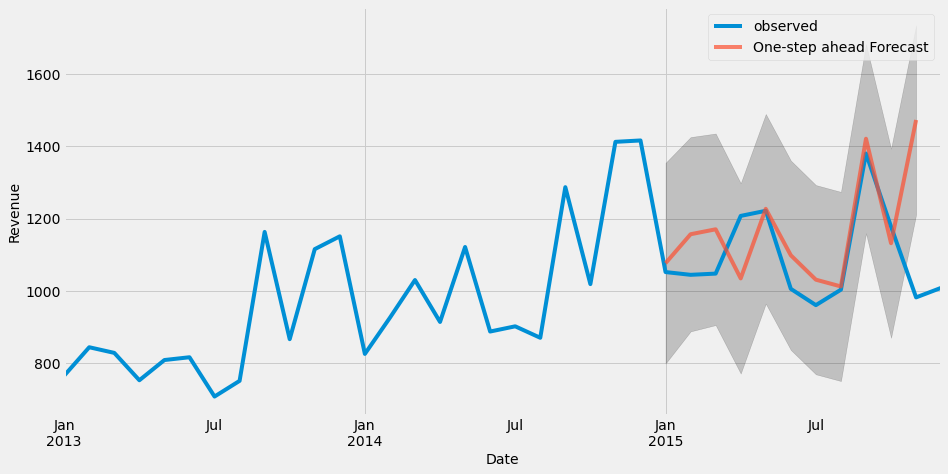

In [21]:
# Validating forecasts
# To understand the accuracy of our forecasts, I compare predicted 
# revenue to real revenue of the time series, and we set forecasts to 
# start at 2015-01-01 to the end of 2015 November.
pred_31 = results_31.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=False)
pred_ci_31 = pred_31.conf_int()

ax = y_31['2013':].plot(label='observed')
pred_31.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci_31.index,
                pred_ci_31.iloc[:, 0],
                pred_ci_31.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Revenue')
plt.legend()

plt.show()
# The line plot is showing the observed values compared to the rolling 
# forecast predictions. Overall, our forecasts align with the true 
# values well, showing an upward trend starts from the beginning of 
# the year and captured the seasonality toward the end of the year.

In [22]:
y_31_forecasted = pred_31.predicted_mean
y_31_truth = y_31['2015-01-01':]
mse_31 = ((y_31_forecasted - y_31_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse_31, 2)))

The Mean Squared Error of our forecasts is 28910.37


In [23]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse_31), 2)))
# In statistics, the mean squared error (MSE) of an estimator measures 
# the average of the squares of the errors — that is, the average squared 
# difference between the estimated values and what is estimated. The MSE 
# is a measure of the quality of an estimator — it is always non-negative,
# and the smaller the MSE, the closer we are to finding the line of best fit.

The Root Mean Squared Error of our forecasts is 170.03


In [24]:
print("Minimum: {:.1f},".format(y_31.min()), "Maximum: {:.1f}".format(y_31.max()))
# Root Mean Square Error (RMSE) tells us that our model was able to forecast
#  the average revenue in the test set within 170 of the real sales. Our 
# average revenue range from around 706 to over 1416. In my opinion, this
# is a pretty good model so far.

Minimum: 706.5, Maximum: 1416.6


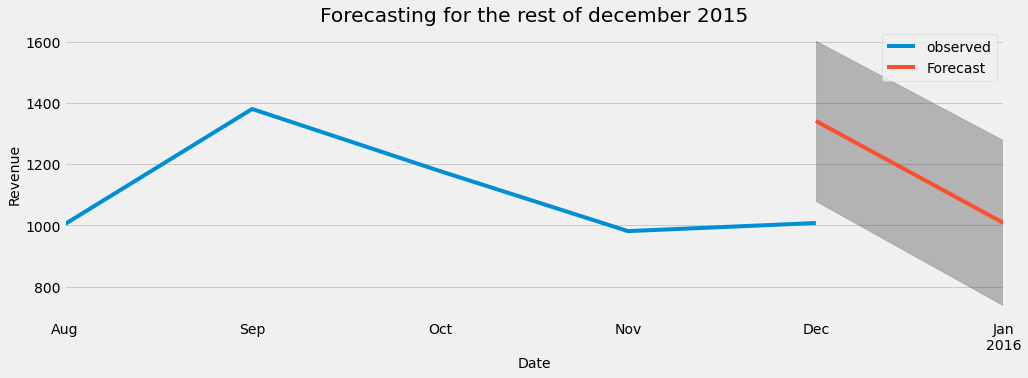

In [25]:
# Producing and visualizing forecasts 

pred_uc_31 = results_31.get_forecast(steps=2)
pred_ci_31 = pred_uc_31.conf_int()

ax = y_31['2015-08-01':].plot(label='observed', figsize=(15, 5))
pred_uc_31.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci_31.index,
                pred_ci_31.iloc[:, 0],
                pred_ci_31.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Revenue')
plt.title('Forecasting for the rest of december 2015')
plt.legend()
plt.show()

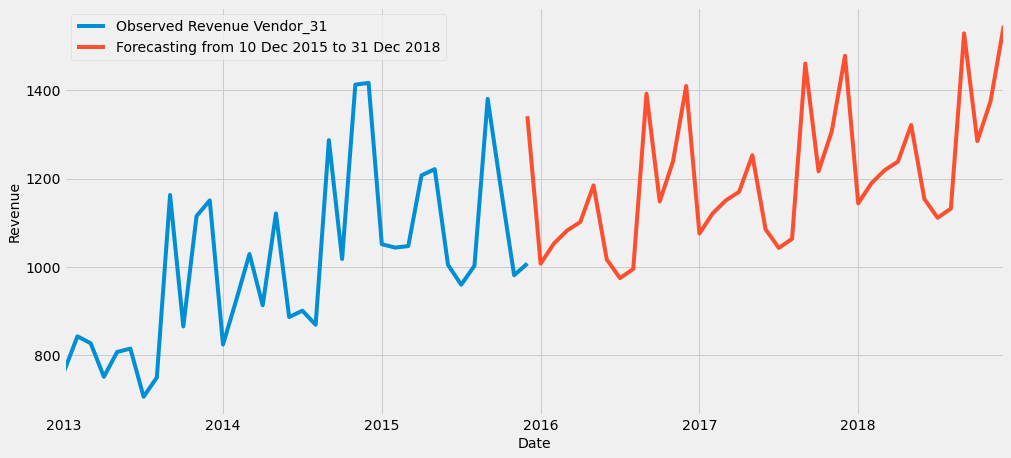

In [26]:
# Revenue Prediction monthly Vendor_id 25, from december 10 2015 to december 31 2018
pred_res_31 = results_31.get_forecast(steps=37).predicted_mean
res_31 = pd.DataFrame([y_31['2015-12-10':], pred_res_31]).mean()
ax = y_31.plot(label='Observed Revenue Vendor_31', figsize=(15, 7))
res_31.plot(ax=ax, label='Forecasting from 10 Dec 2015 to 31 Dec 2018')
ax.set_xlabel('Date')
ax.set_ylabel('Revenue')
plt.legend()
plt.show()
#res_31

In [27]:
# Our model clearly captured seasonality. As we forecast further out 
# into the future, it is natural to become less confident in our 
# values. This is reflected by the confidence intervals generated by our 
# model, which grow larger as we move further out into the future.